In [1]:
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [2]:
dataroot = '/kaggle/input/celeba-dataset/img_align_celeba'

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

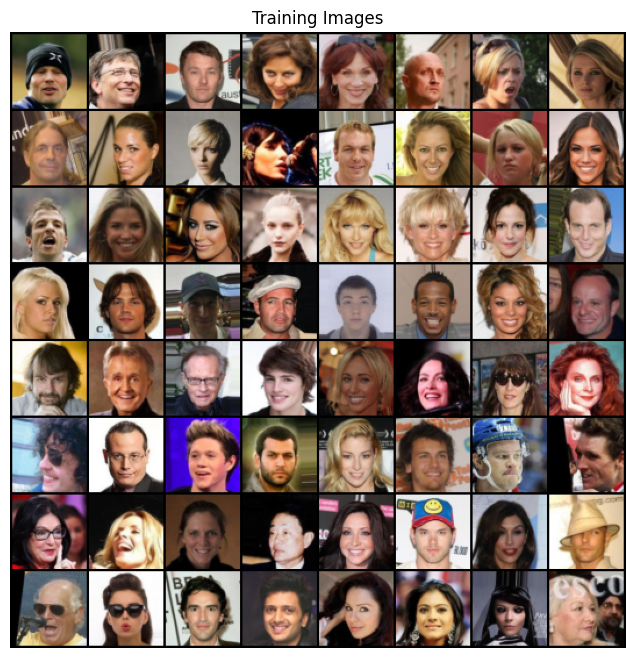

In [3]:
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [4]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [5]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [6]:
# Create the generator
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [7]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [8]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [9]:
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)


        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f \t %s'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2,device))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/5][0/1583]	Loss_D: 1.7959	Loss_G: 6.4627	D(x): 0.6612	D(G(z)): 0.6682 / 0.0028 	 cuda:0
[0/5][50/1583]	Loss_D: 0.1969	Loss_G: 28.1000	D(x): 0.9009	D(G(z)): 0.0000 / 0.0000 	 cuda:0
[0/5][100/1583]	Loss_D: 0.2995	Loss_G: 5.8863	D(x): 0.8918	D(G(z)): 0.0729 / 0.0066 	 cuda:0
[0/5][150/1583]	Loss_D: 0.4804	Loss_G: 5.7330	D(x): 0.9531	D(G(z)): 0.3073 / 0.0064 	 cuda:0
[0/5][200/1583]	Loss_D: 2.1421	Loss_G: 6.5265	D(x): 0.3417	D(G(z)): 0.0053 / 0.0063 	 cuda:0
[0/5][250/1583]	Loss_D: 0.3096	Loss_G: 4.8922	D(x): 0.8415	D(G(z)): 0.0188 / 0.0264 	 cuda:0
[0/5][300/1583]	Loss_D: 0.4274	Loss_G: 4.6736	D(x): 0.7923	D(G(z)): 0.0974 / 0.0187 	 cuda:0
[0/5][350/1583]	Loss_D: 0.7188	Loss_G: 5.9228	D(x): 0.9033	D(G(z)): 0.3855 / 0.0068 	 cuda:0
[0/5][400/1583]	Loss_D: 0.6177	Loss_G: 3.9183	D(x): 0.7463	D(G(z)): 0.1780 / 0.0376 	 cuda:0
[0/5][450/1583]	Loss_D: 0.3608	Loss_G: 4.7070	D(x): 0.9239	D(G(z)): 0.2043 / 0.0209 	 cuda:0
[0/5][500/1583]	Loss_D: 1.0300	Loss_G: 2.2099	

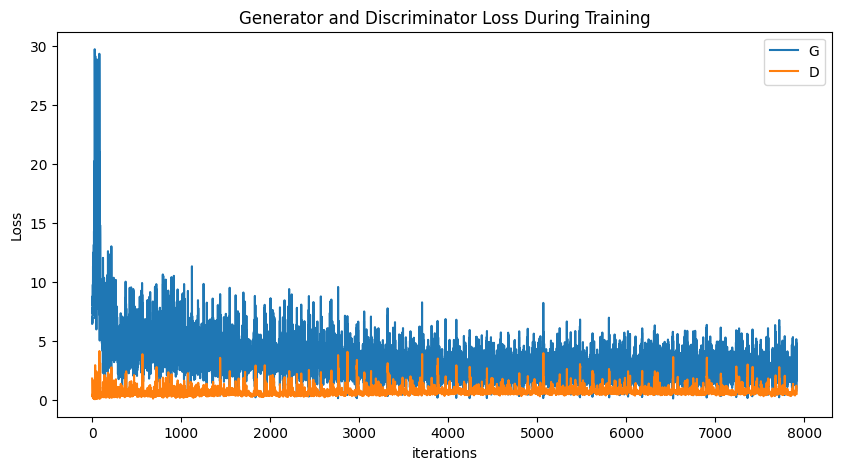

In [10]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

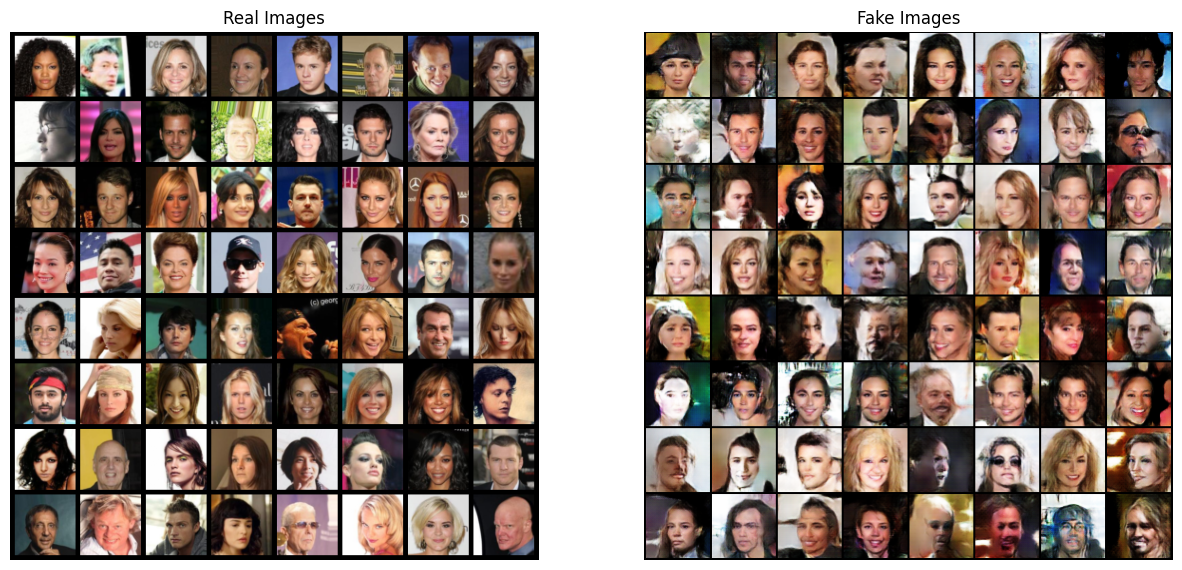

In [11]:
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

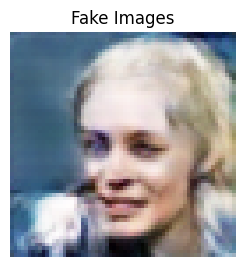

In [12]:
import torchvision.transforms as T

# Load the saved generator model
 # Assuming GeneratorModelClass is the class for your generator model
netG.load_state_dict(torch.load("/kaggle/input/gan/pytorch/gan3/1/generator_model (2).pth"))
netG.eval()  # Set the model to evaluation mode if needed
        
img_list=[]
fixed_noise = torch.randn(1, nz, 1, 1, device=device)
for i in range(9):
    with torch.no_grad():
        fake_image = netG(fixed_noise).detach().cpu()
        img_list.append(vutils.make_grid(fake_image, padding=2, normalize=True))

    
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()


In [13]:
# import torch
# import matplotlib.pyplot as plt

# fixed_noise = torch.randn(1, 100, 1, 1, device=device)


# # Generate fake images using the trained generator
# with torch.no_grad():
#     fake_image = netG(fixed_noise).detach().cpu()
    
# fake_image.size()
    

# # Assuming generated_image_tensor is your generated image tensor of size (1, 3, 64, 64)

# # Convert the tensor to a numpy array and transpose it to (64, 64, 3) format
# generated_image_numpy = fake_image.squeeze().permute(1, 2, 0).cpu().numpy()

# # Display the image using matplotlib
# plt.imshow(generated_image_numpy)
# plt.axis('off')  # Remove axis
# plt.show()


In [14]:
# # saving gen model
# import numpy as np

# # Assuming netG is your trained generator model
# # Extract the weights of the generator model
# # generator_weights = []
# # for param in netG.parameters():
# #     generator_weights.append(param.data.cpu().numpy().flatten())

# # # Convert the list of weights to a numpy array
# # generator_weights_array = np.concatenate(generator_weights)

# # # Specify the file path where you want to save the weights
# # generator_weights_path = "generator_weights.npy"


# # # Save the weights array
# # np.save(generator_weights_path, generator_weights_array)

# # Assuming netG is your trained generator model
# # Specify the file path where you want to save the model
# generator_model_path = "generator_model.pth"

# # Save the trained generator model
# torch.save(netG.state_dict(), generator_model_path)



In [15]:
# loading gen model
# Load the saved weights array
# loaded_generator_weights = np.load("generator_weights.npy")

# # Assuming netG is instantiated with the same architecture as when weights were saved
# # Load the weights into the generator model
# with torch.no_grad():
#     for i, param in enumerate(netG.parameters()):
#         param.data.copy_(torch.tensor(loaded_generator_weights[i].reshape(param.data.shape)))

        
        

        

In [16]:
# Define the Encoder architecture
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),  # Adjusted kernel size to fit input size
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, 3, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 256, 3, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 512, 3, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 1024, 3, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(1024),
            nn.Conv2d(1024, 100, 3, 1, 0),  # Adjusted kernel size to fit input size
            nn.Sigmoid()  # Output in the range [0, 1]
        )

    def forward(self, x):
        return self.main(x)

In [17]:
#encoder


import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

start_number = 162771
end_number = 182637         
filtered_indices = list(range(start_number, end_number + 1))        
filtered_dataset = torch.utils.data.Subset(dataset, filtered_indices)
filtered_dataloader = DataLoader(filtered_dataset, batch_size=512, shuffle=True)



# Load the pre-trained generator
# Initialize the encoder
encoder = Encoder().to(device)
# Define the MSE loss function
criterion = nn.MSELoss()

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set up data loaders (Assuming you have a DataLoader for your dataset)
train_loader = DataLoader(dataset, batch_size=512, shuffle=True)

# Set hyperparameters
lr = 0.0002
beta1 = 0.5

# Initialize optimizer
optimizer = optim.Adam(encoder.parameters(), lr=lr, betas=(beta1, 0.999))
epochs12=4
# Training loop
for epoch in range(epochs12):
    for i, data in enumerate(filtered_dataloader, 0):
        # Move data to device
        inputs, _ = data
        inputs = inputs.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Encode input images to obtain 'z vectors'
        encoded_z = encoder(inputs)

        encoder_output = encoded_z[:, :, 0, 0].unsqueeze(-1).unsqueeze(-1)

        # Generate images using the pre-trained generator
        generated_images = netG(encoder_output)

#         generated_images_resized = torch.nn.functional.interpolate(generated_images, size=inputs.shape[2:], mode='nearest')

        # Compute loss (MSE between input images and generated images)
        loss = criterion(inputs, generated_images)

        # Backpropagation
        loss.backward()
        optimizer.step()
        # Print progress
        if i % 100 == 0:
            print(f"Epoch [{epoch}/{epochs12}], Step [{i}/{len(train_loader)}], Loss: {loss.item()}")

# Save the trained encoder
path = "encoder.pth"

# Save the trained generator model
torch.save(encoder.state_dict(), path)


Epoch [0/4], Step [0/396], Loss: 0.43324026465415955
Epoch [1/4], Step [0/396], Loss: 0.13349300622940063
Epoch [2/4], Step [0/396], Loss: 0.12126001715660095
Epoch [3/4], Step [0/396], Loss: 0.12625965476036072


torch.Size([3, 64, 64])
torch.Size([1, 3, 64, 64])
torch.Size([1, 100, 2, 2])
torch.Size([1, 100, 1, 1])
torch.Size([1, 3, 64, 64])


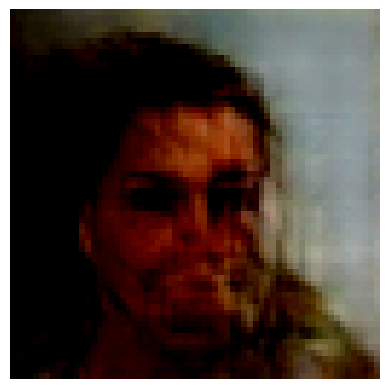

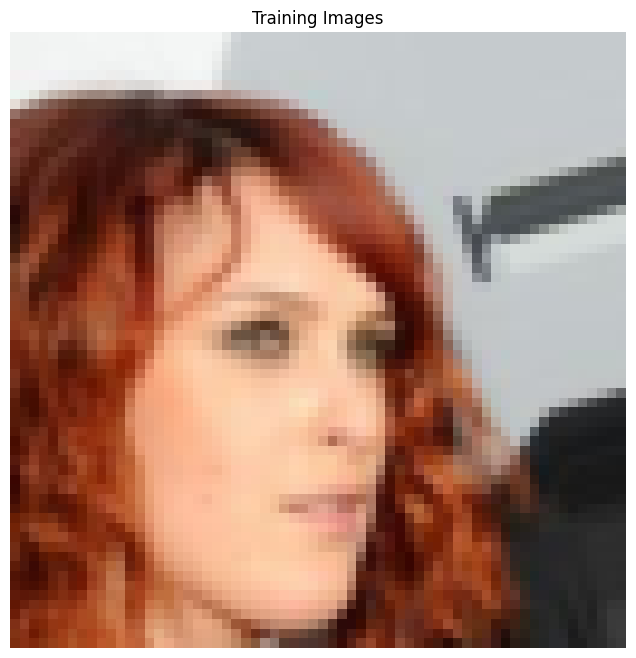

In [18]:


from PIL import Image
import torchvision.transforms as transforms
import torch
from torch.utils.data import DataLoader
encoder = Encoder().to(device)

encoder.load_state_dict(torch.load("/kaggle/input/encoder-for-2/pytorch/encoder3/1/encoder (4).pth"))
encoder.eval()  # Set the model to evaluation mode if needed

image_path = "/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/000003.jpg"
image = Image.open(image_path)
image_size=64

transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                            ])
# Preprocess the image
image = transform(image)
print(image.size())
image = image.unsqueeze(0)
print(image.size())
# Convert the image to a PyTorch tensor
image=image.to(device)

# Pass the tensor through the encoder to obtain the encoded 'z vector'
with torch.no_grad():
    encoded_z = encoder(image)
    
print(encoded_z.size())
encoder_output = encoded_z[:, :, 0, 0].unsqueeze(-1).unsqueeze(-1)
print(encoder_output.size())
# Print or use the encoded 'z vector'
with torch.no_grad():
    fake_image = netG(encoder_output).detach().cpu()
    
print(fake_image.size())
   
generated_image_numpy = fake_image.squeeze().permute(1, 2, 0).cpu().numpy()

# Display the image using matplotlib
plt.imshow(generated_image_numpy)
plt.axis('off')  # Remove axis
plt.show()

train_loader = DataLoader(dataset, batch_size=512,shuffle=True)

real_batch = next(iter(train_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:1], padding=2, normalize=True).cpu(),(1,2,0)))


# for i, data in enumerate(train_loader, 0):
#     # Move data to device
#     inputs, _ = data
#     inputs = inputs.to(device)
#     print(inputs.size())
#     encoded_z = encoder(inputs)
    
#     encoder_output = encoded_z[:, :, 0, 0].unsqueeze(-1).unsqueeze(-1)
#     print(encoder_output.size())
    
#     fake_image = netG(encoder_output).detach().cpu()
    
# #     generated_image_numpy = fake_image.squeeze().permute(1, 2, 0).cpu().numpy()

#     for i in (fake_image.size()):
        
#     # Display the image using matplotlib
#         real=inputs[i-1].squeeze().permute(1, 2, 0).cpu().numpy()
#         generated_image_numpy = fake_image[i-1].squeeze().permute(1, 2, 0).cpu().numpy()
#         plt.imshow(real)
#         plt.title("Real")
#         plt.axis('off')
#         plt.show()# Remove axis
        
#         plt.imshow(generated_image_numpy)
#         plt.axis('off') 
#         plt.title("FAKE")# Remove axis
#         plt.show()

In [19]:
def findimage(dataset,filename):
    target_image = None
    for image_path, _ in dataset.imgs:
        name = image_path.split('/')[-1].split('.')[0]  # Extract filename without extension
        if name == filename:
            target_image = image_path
            break
    image =Image.open(target_image)
    transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                            ])
    # Preprocess the image
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    image = transform(image)
    image = image.unsqueeze(0)
    image=image.to(device)
    return image

def normalize_image(image):
    min_val = image.min()
    max_val = image.max()
    normalized_image = (image - min_val) / (max_val - min_val)
    return normalized_image

def showimage(tensor):
    img_list=[]
    with torch.no_grad():
        fake_image = netG(tensor).detach().cpu()
        img_list.append(vutils.make_grid(fake_image,nrow=3, padding=2, normalize=True))

    plt.subplot(1,2,2)
    plt.axis("off")
    plt.imshow(np.transpose(img_list[-1],(1,2,0)))
    plt.show()
    
    interpolated_samples = []
    for i in range(-4, 5):
        noise = torch.FloatTensor(tensor.size()).uniform_(-0.25, 0.25).to(device)
        input_with_noise = tensor + noise * i
        with torch.no_grad():
            generated_sample = netG(input_with_noise).detach().cpu()
            interpolated_samples.append(generated_sample)

    # Convert tensors back to PIL images for visualization
    input_image = normalize_image(fake_image.squeeze(0).cpu().detach().numpy())
    interpolated_images = [normalize_image(sample.squeeze(0).cpu().detach().numpy()) for sample in interpolated_samples]

    # Display the images in a grid with original in the center
    num_cols = 3
    num_rows = 3
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))

    # Set the center cell for the original image
    center_row = num_rows // 2
    center_col = num_cols // 2
    axes[center_row, center_col].imshow(input_image.transpose(1, 2, 0))
    axes[center_row, center_col].axis('off')
    axes[center_row, center_col].set_title('Original')

    # Fill the grid with the interpolated images
    idx = 0
    for row in range(num_rows):
        for col in range(num_cols):
            if row != center_row or col != center_col:
                axes[row, col].imshow(interpolated_images[idx].transpose(1, 2, 0))
                axes[row, col].axis('off')
                axes[row, col].set_title(f'Interpolated {idx}')
                idx += 1

    plt.tight_layout()
    plt.show()
    
def showimg(tensor):
    tensor=tensor.cpu()
    image_array = tensor.numpy()
    # Display the image array using matplotlib
    plt.imshow(image_array.transpose(1, 2, 0))  # Transpose dimensions to (64, 64, 3) for RGB image
    plt.axis('off')  # Turn off axis
    plt.show()

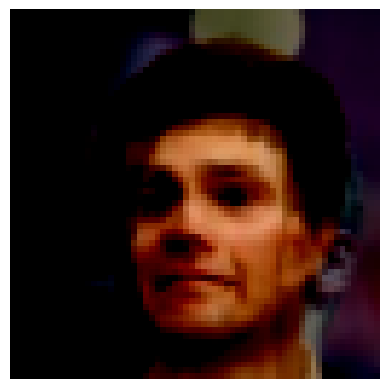

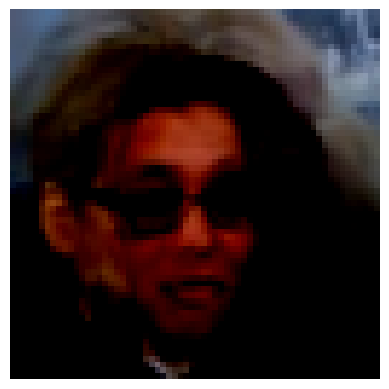

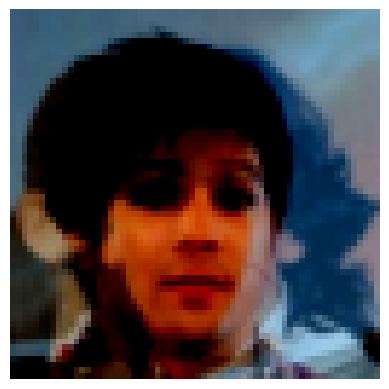

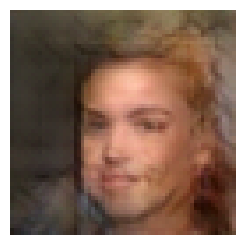

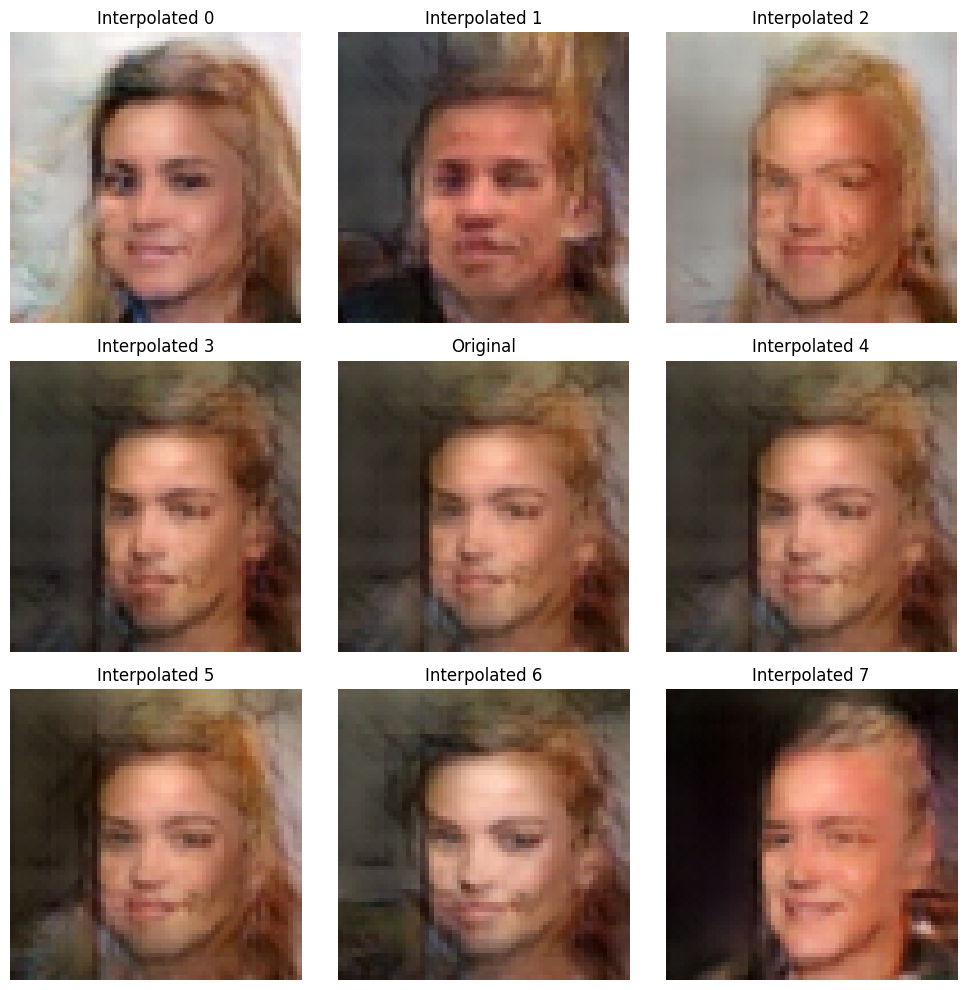

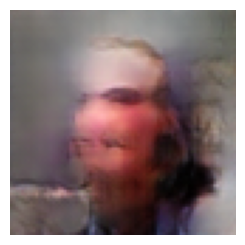

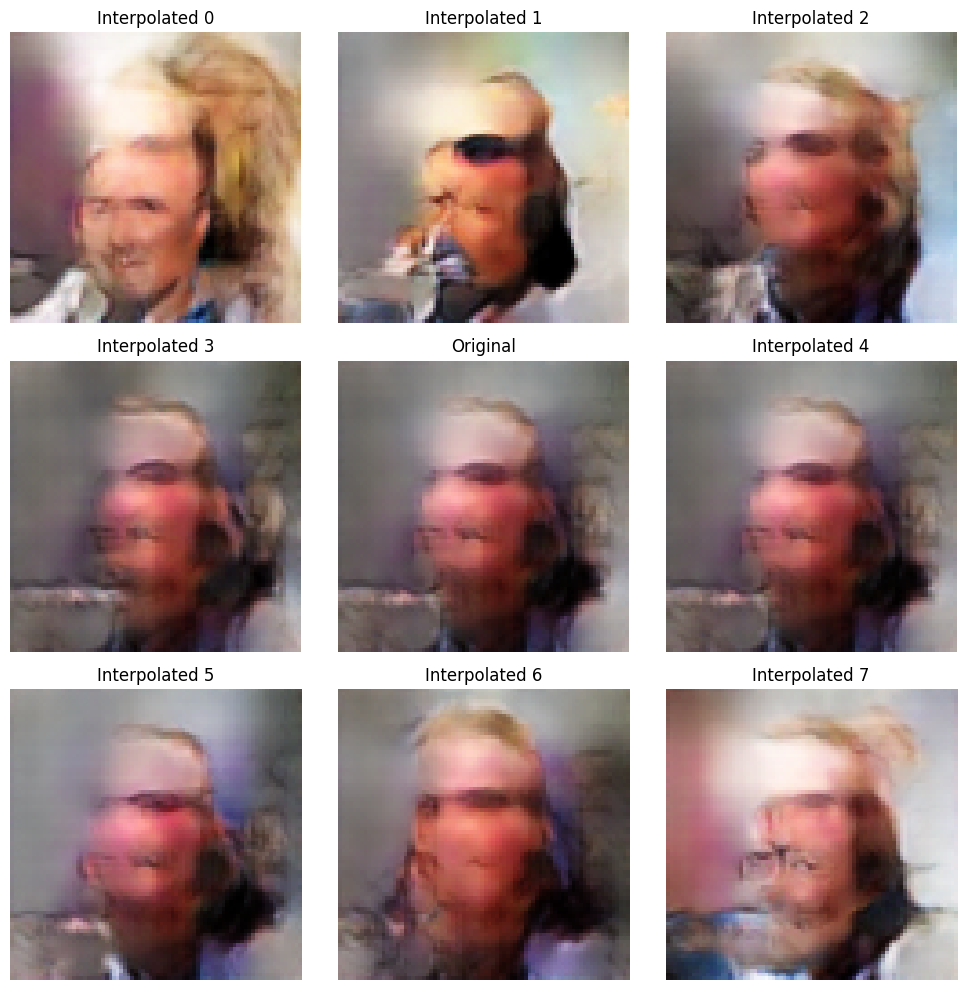

In [20]:
from torchvision.utils import make_grid
start_number = 182638
end_number = 202599
# filtered_indices = []
# for idx, (image_path, _) in enumerate(dataset.imgs):
#     filename = os.path.splitext(os.path.basename(image_path))[0]
#     if start_filename <= filename <= end_filename:
#         filtered_indices.append(idx)
        
filtered_indices = list(range(start_number, end_number + 1))        
filtered_dataset = torch.utils.data.Subset(dataset, filtered_indices)
filtered_dataloader = DataLoader(filtered_dataset, batch_size=batch_size, shuffle=True)


#DOING Men without glasses + People with glasses - People without glasses
mwg1=findimage(dataset,"195124")
mwg2=findimage(dataset,"195128")
mwg3=findimage(dataset,"195142")

pg1=findimage(dataset,"195136")
pg2=findimage(dataset,"195137")
pg3=findimage(dataset,"195251")

pwg1=findimage(dataset,"195176")
pwg2=findimage(dataset,"195177")
pwg3=findimage(dataset,"195172")


a= (mwg1 + mwg2 + mwg3) / 3
a1=encoder(a)
a = torch.squeeze(a, dim=0)
showimg(a)


a= (pg1 + pg2 + pg3) / 3
a2=encoder(a)
a = torch.squeeze(a, dim=0)
showimg(a)


a= (pwg1 + pwg2 + pwg3) / 3
a3=encoder(a)
a = torch.squeeze(a, dim=0)
showimg(a)



o=a1+a2-a3

with torch.no_grad():
    mwg= (encoder(mwg1) + encoder(mwg2) + encoder(mwg3)) /3
    pg= (encoder(pg1) + encoder(pg2) + encoder(pg3)) /3
    pwg= (encoder(pwg1) + encoder(pwg2) + encoder(pwg3)) /3

    
overall=mwg + pg - pwg
overall = overall[:, :, 0, 0].unsqueeze(-1).unsqueeze(-1)
showimage(overall)
showimage(o)

# Generate and display 9 fake images in a grid

    

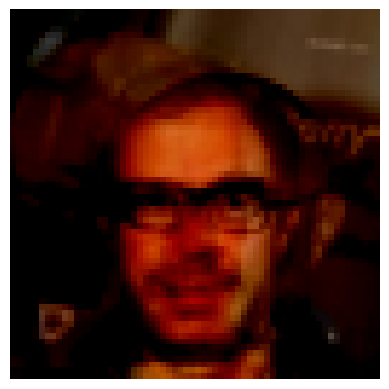

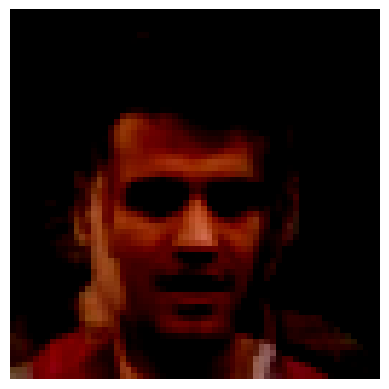

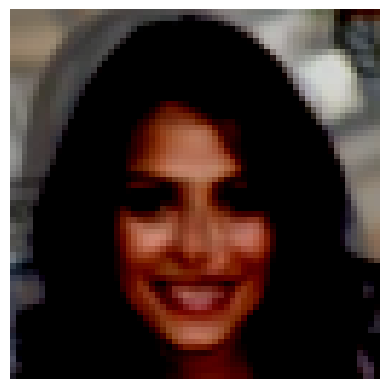

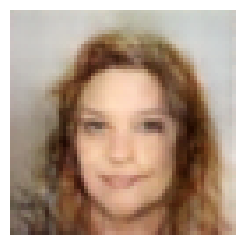

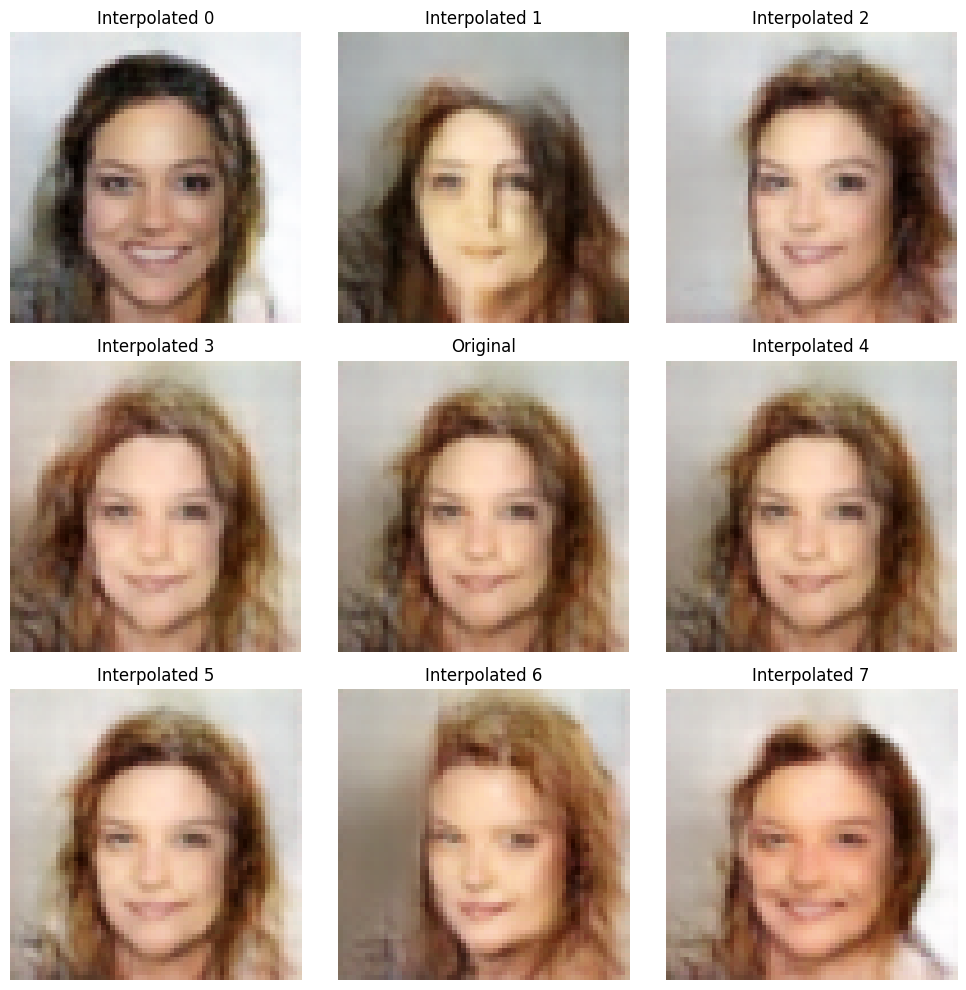

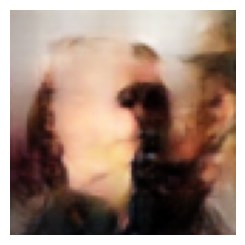

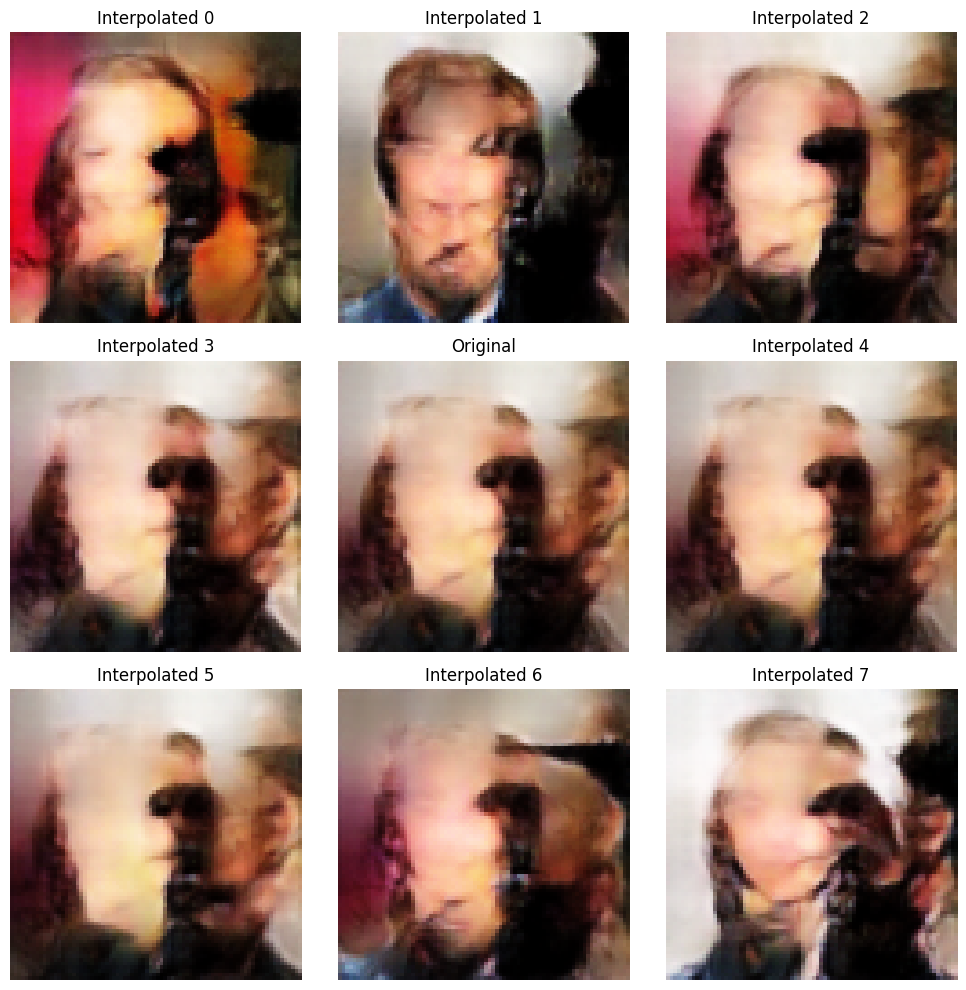

In [21]:
#Men with glasses - Men without glasses + Women without glasses
mg1=findimage(dataset,"195352")
mg2=findimage(dataset,"195342")
mg3=findimage(dataset,"195384")

mwg1=findimage(dataset,"195370")
mwg2=findimage(dataset,"195388")
mwg3=findimage(dataset,"195387")

wwg1=findimage(dataset,"195381")
wwg2=findimage(dataset,"195382")
wwg3=findimage(dataset,"195385")

a= (mg1 + mg2 + mg3) / 3
a1=encoder(a)
a = torch.squeeze(a, dim=0)
showimg(a)

a= (mwg1 + mwg2 + mwg3) / 3
a2=encoder(a)
a = torch.squeeze(a, dim=0)
showimg(a)


a= (wwg1 + wwg2 + wwg3) / 3
a3=encoder(a)
a = torch.squeeze(a, dim=0)
showimg(a)



o=a1-a2+a3


with torch.no_grad():
    mwg= (encoder(mwg1) + encoder(mwg2) + encoder(mwg3)) /3
    mg= (encoder(mg1) + encoder(mg2) + encoder(mg3)) /3
    wwg= (encoder(wwg1) + encoder(wwg2) + encoder(wwg3)) /3

overall=mg - mwg + wwg

overall = overall[:, :, 0, 0].unsqueeze(-1).unsqueeze(-1)
showimage(overall)
showimage(o)

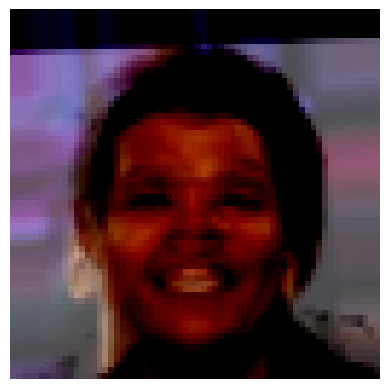

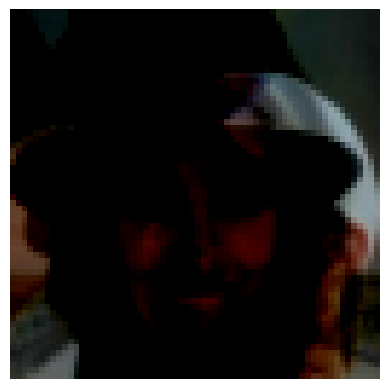

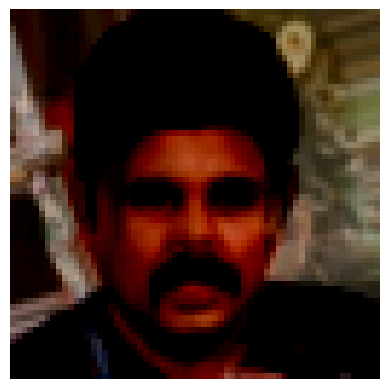

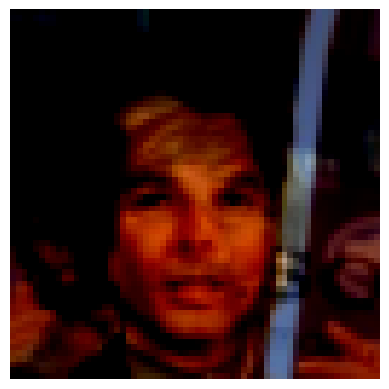

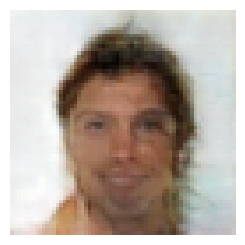

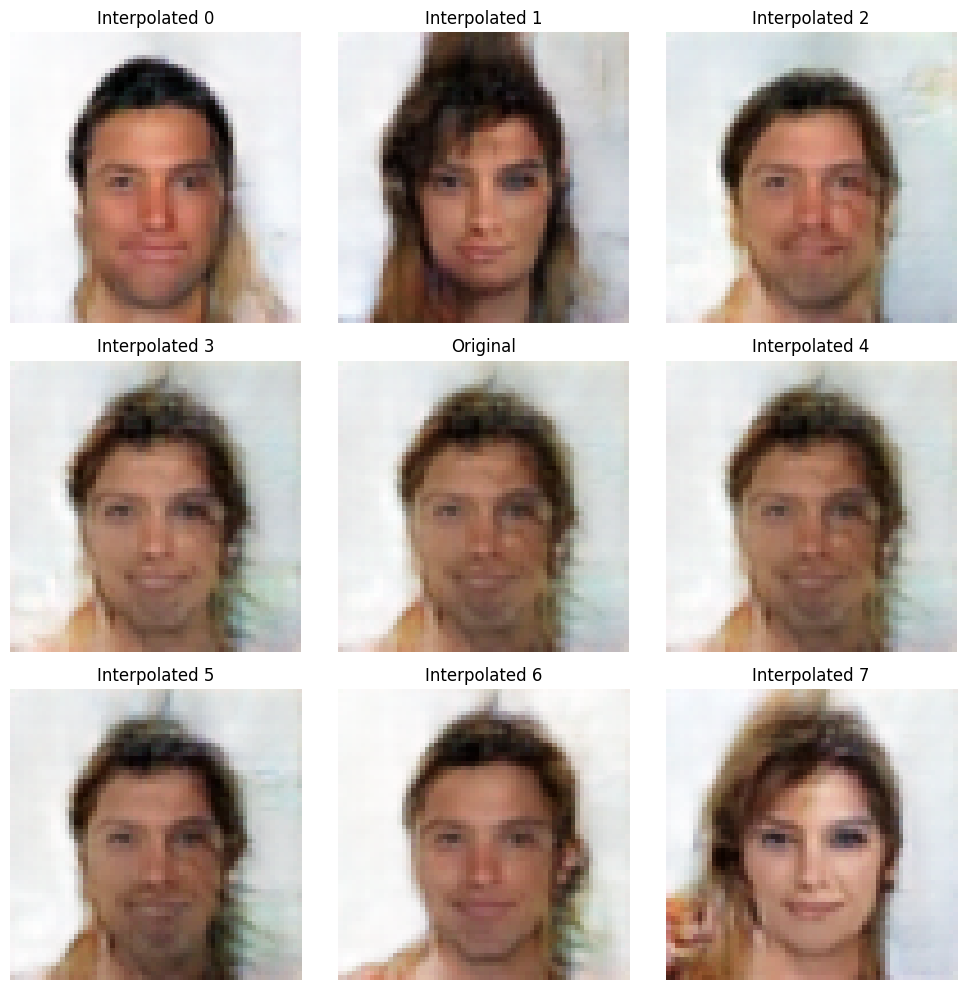

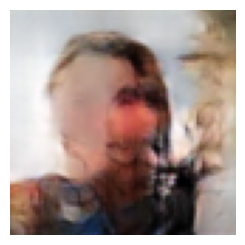

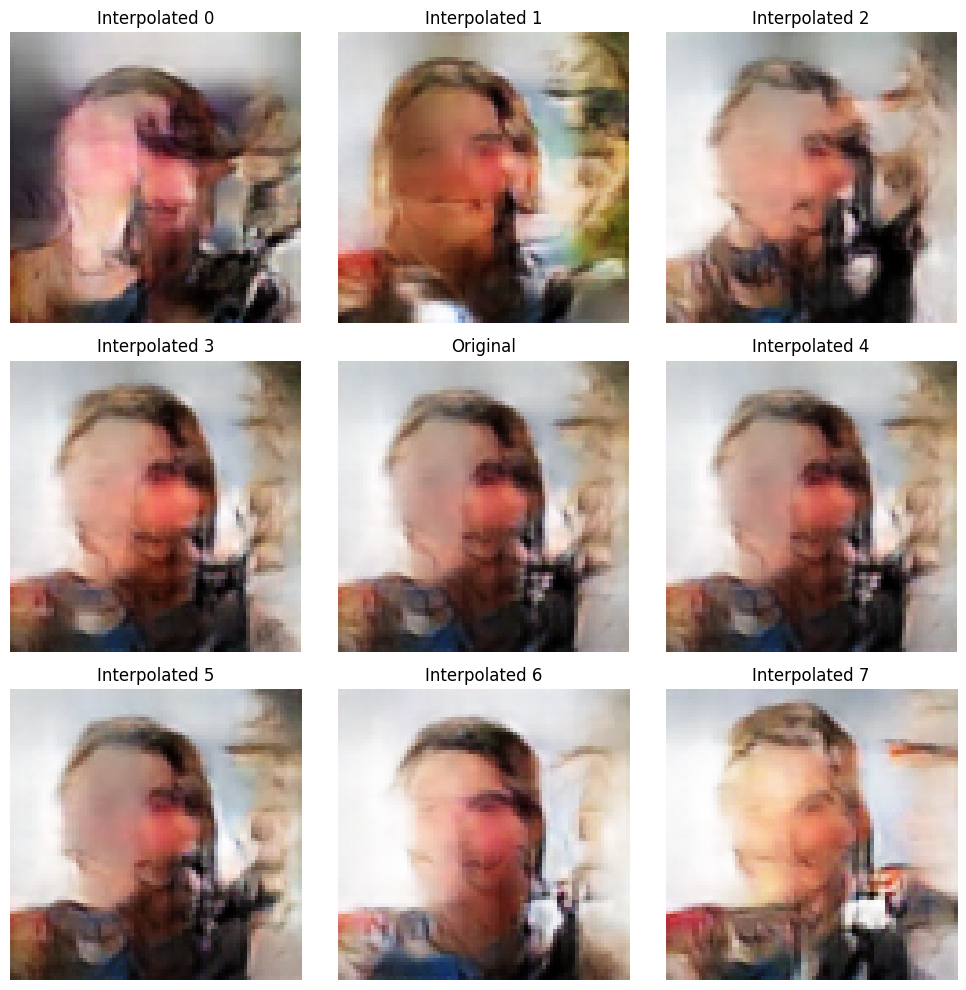

In [22]:
#Smiling Men + People with Hat - People with Hat + People with Mustache - People without Mustache
sm1=findimage(dataset,"195860")
sm2=findimage(dataset,"195868")
sm3=findimage(dataset,"195877")

ph1=findimage(dataset,"195931")
ph2=findimage(dataset,"196056")
ph3=findimage(dataset,"196123")

pm1=findimage(dataset,"195613")
pm2=findimage(dataset,"195769")
pm3=findimage(dataset,"195910")

pwm1=findimage(dataset,"193887")
pwm2=findimage(dataset,"193952")
pwm3=findimage(dataset,"194004")


a= (sm1 + sm2 + sm3) / 3
a1=encoder(a)
a = torch.squeeze(a, dim=0)
showimg(a)

a= (ph1 + ph2 + ph3) / 3
a2=encoder(a)
a = torch.squeeze(a, dim=0)
showimg(a)

a= (pm1 + pm2 + pm3) / 3
a3=encoder(a)
a = torch.squeeze(a, dim=0)
showimg(a)

a= (pwm1 + pwm2 + pwm3) / 3
a4=encoder(a)
a = torch.squeeze(a, dim=0)
showimg(a)

o=a1+a2-a2+a3-a4
with torch.no_grad():
    sm= (encoder(sm1) + encoder(sm2) + encoder(sm3)) /3
    ph= (encoder(ph1) + encoder(ph2) + encoder(ph3)) /3
    pm= (encoder(pm1) + encoder(pm2) + encoder(pm3)) /3
    pwm= (encoder(pwm1) + encoder(pwm2) + encoder(pwm3)) /3
    

overall=sm + ph -ph + pm - pwm

overall = overall[:, :, 0, 0].unsqueeze(-1).unsqueeze(-1)
showimage(overall)
showimage(o)
if torch.equal(pg, pwg):
    print("whyyy")